In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns

In [238]:
from api import DataAPI
# takes a specific player and gets player data
player = 'mikal bridges'
api = DataAPI()
df = api.get_player_data(player)
df = df.reset_index(drop=False)
df.head()

,date,mp,home,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,...,ast_pct,stl_pct,blk_pct,tov_pct,usg_pct,off_rtg,def_rtg,bpm,opponent,team
0,2020-12-23,35.95,1,5.0,11.0,0.455,4.0,7.0,0.571,4.0,...,0.0,0.0,5.6,0.0,15.6,145.0,103.0,7.4,"josh richardson,luka doncic,dorian finney-smit...","devin booker,chris paul,jae crowder,deandre ay..."
1,2020-12-26,26.82,0,4.0,8.0,0.500,1.0,5.0,0.200,0.0,...,5.3,1.8,8.5,0.0,12.5,119.0,103.0,4.7,"de'aaron fox,buddy hield,harrison barnes,richa...","devin booker,chris paul,jae crowder,deandre ay..."
2,2020-12-27,36.30,0,9.0,15.0,0.600,4.0,8.0,0.500,0.0,...,3.9,0.0,2.5,0.0,18.4,139.0,103.0,5.5,"buddy hield,harrison barnes,marvin bagley iii,...","devin booker,deandre ayton,chris paul,jae crow..."
3,2020-12-29,30.05,1,4.0,7.0,0.571,1.0,2.0,0.500,4.0,...,0.0,3.5,0.0,0.0,13.7,163.0,92.0,7.8,"zion williamson,brandon ingram,steven adams,lo...","deandre ayton,devin booker,chris paul,jae crow..."
4,2020-12-31,36.53,0,6.0,9.0,0.667,4.0,6.0,0.667,0.0,...,0.0,2.8,2.6,0.0,11.4,163.0,97.0,12.1,"donovan mitchell,mike conley,royce o'neale,rud...","jae crowder,devin booker,chris paul,deandre ay..."


In [239]:
# for a specific player, gets odd data
odds_df = api.get_player_odds_data(player)
odds_df = odds_df.reset_index(drop=False)
first_date = odds_df['date'].unique()[0]

# specifies a market 
market = 'player_points_over_under'
odds_df = odds_df[odds_df['market'] == market]
odds_df.head()

,date,game_id,book_key,market,player,over_under,value,odds,timestamp,home_team,away_team
1,2023-03-21,4f3ec1b127556ad3003670d430008e29,fanduel,player_points_over_under,mikal bridges,False,22.5,110,2023-03-22T00:30:01,Brooklyn Nets,Cleveland Cavaliers
2,2023-03-21,4f3ec1b127556ad3003670d430008e29,fanduel,player_points_over_under,mikal bridges,False,23.5,-112,2023-03-22T00:00:01,Brooklyn Nets,Cleveland Cavaliers
3,2023-03-21,4f3ec1b127556ad3003670d430008e29,fanduel,player_points_over_under,mikal bridges,False,24.5,-132,2023-03-22T00:45:02,Brooklyn Nets,Cleveland Cavaliers
9,2023-03-21,4f3ec1b127556ad3003670d430008e29,fanduel,player_points_over_under,mikal bridges,False,21.5,-130,2023-03-22T01:00:02,Brooklyn Nets,Cleveland Cavaliers
20,2023-03-21,4f3ec1b127556ad3003670d430008e29,fanduel,player_points_over_under,mikal bridges,False,20.5,-106,2023-03-22T01:15:01,Brooklyn Nets,Cleveland Cavaliers


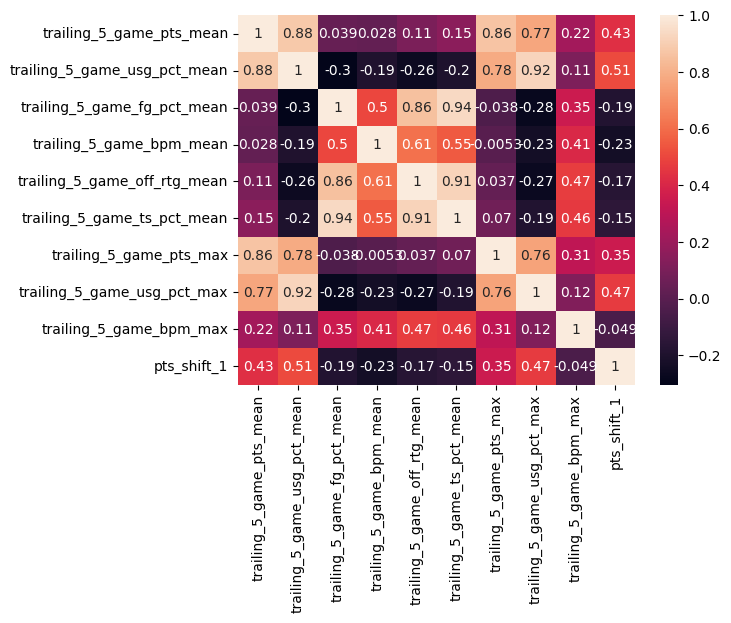

In [240]:
'''
Function: calculates trailing 5-game rolling statistics for various metrics.
It then analyzes the correlations between these features and the target (pts) using a heatmap.
'''
# get trailing 10 game minutes per game and compare it to current game minutes
window = 5
# get trailing 10 of [pts, reb, ast, usg_pct, mp, fg_pct]
mean_features = ['pts', 'usg_pct', 'fg_pct', 'bpm', 'off_rtg', 'ts_pct']
var_features = []
max_features = ['pts', 'usg_pct', 'bpm']
range_features = ['pts', 'usg_pct', 'bpm']
target = 'pts'

feature_df = pd.DataFrame()

for feature in mean_features:
    feature_df[f'trailing_{window}_game_{feature}_mean'] = df[feature].rolling(window).mean()

for feature in var_features:
    feature_df[f'trailing_{window}_game_{feature}_var'] = df[feature].rolling(window).var()

for feature in max_features:
    feature_df[f'trailing_{window}_game_{feature}_max'] = df[feature].rolling(window).max()

feature_df[f'{target}_shift_1'] = df[target].shift(window)

feature_df = feature_df.dropna()
corr_matrix = feature_df.corr()

sns.heatmap(corr_matrix, annot=True)
plt.show()

In [241]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from warnings import filterwarnings

filterwarnings('ignore')

'''
Function: takes in a model, features and a target variable to compute predicted probabilities
Returns: score representing the sum of adjusted confidence scores'''
def custom_scorer(model, X, y):
    y_proba = model.predict_proba(X)
    return np.where(
        y == np.argmax(y_proba, axis=1), 
        -np.min(y_proba, axis=1), 
        -(np.max(y_proba, axis=1) - np.min(y_proba, axis=1))
    ).sum()

In [242]:
param_grid = {
    'C': [0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear']
}
# The function fits the cross-validated model to the data and returns the resulting GridSearchCV object.
def tune_model(n_splits, X, y, verbose=0):

    tscv = TimeSeriesSplit(n_splits=n_splits, gap=0, max_train_size=None, test_size=5)
    cv = GridSearchCV(
        LogisticRegression(),
        param_grid=param_grid, 
        cv=tscv, 
        scoring=make_scorer(custom_scorer, needs_proba=True),
        verbose=verbose,
    )
    cv.fit(X, y)

    # print(f'Best Params: {cv.best_params_}')
    return cv

In [243]:
'''
For a given threshold (value), we print the player name, market, and threshold value.
Additionally, calculates and prints the ratio of True to total items in y (Data T / F ratio), 
'''
value = 27.5
# feature_df = feature_df.dropna()
X = feature_df.drop(f'{target}_shift_1', axis=1)
y = feature_df[f'{target}_shift_1'] > value

print('Player:', player, '| Market:', market, '| Value:', value)
print('Data T / F ratio:', round(y[y == True].count() / y.count(), 3), '-', y.count(), 'items')


Player: mikal bridges | Market: player_points_over_under | Value: 27.5
Data T / F ratio: 0.062 - 273 items


In [244]:
bets_df = odds_df.groupby(['date', 'value', 'over_under'])['odds'].max().reset_index(drop=False)
bets_df = bets_df.merge(df[['date', 'pts']], on='date', how='left')
feature_df['date'] = df['date']
bets_df.dropna(inplace=True)
dates = bets_df['date'].unique()

n_splits = 5

# model predictions 
def get_prediction(X, y, value, over_under, features):
    y = y > value
    model = tune_model(n_splits, X, y)
    return model.predict_proba(features)[0][int(over_under)]

# implied probabilities 
def get_implied_prob(odds):
    if odds < 0:
        return abs(odds) / (abs(odds) + 100)
    else:
        return 100 / (odds + 100)

# expected value
def get_EV(odds, prob):
    if odds < 0:
        return prob * (100 / (abs(odds))) - (1 - prob)
    else:
        return prob * (odds / 100) - (1 - prob)

returns_df = pd.DataFrame()

# For each bet on a given date, applies get_prediction to estimate probabilities, calculates implied probabilities, and computes expected values.
for date in dates:
    day_df = bets_df[bets_df['date'] == date]
    features = feature_df[feature_df['date'] < date].tail(1).drop(['date', 'pts_shift_1'], axis=1)
    X = feature_df[feature_df['date'] < date].drop(['date', 'pts_shift_1'], axis=1)
    y = feature_df[feature_df['date'] < date]['pts_shift_1']

    # X = StandardScaler().fit_transform(X)
    try:
        day_df['pred'] = day_df.apply(lambda x: get_prediction(X, y, x['value'], x['over_under'], features), axis=1)
        day_df['implied_prob'] = day_df['odds'].apply(lambda x: get_implied_prob(x))
        day_df['EV'] = day_df.apply(lambda x: get_EV(x['odds'], x['pred']), axis=1)
        returns_df = pd.concat([returns_df, day_df])
    except:
        continue
    
# returns a file with the above data 
returns_df.to_csv('returns.csv', index=False)


In [245]:
T = .6
# It returns 1 if the prediction was correct, -1 if incorrect, and 0 if no confident prediction was made
def correct(pred, over_under, pts, value):
    if pred > T:
        if over_under == 1:
            if pts >= value:
                return 1
            else:
                return -1
        else:
            if pts < value:
                return -1
            else:
                return 1
    return 0

# Applies the correct function to each row in returns_df to evaluate each prediction's outcome, storing the results in a new column correct.
returns_df['correct'] = returns_df.apply(lambda x: correct(x['pred'], x['over_under'], x['pts'], x['value']), axis=1)

correct = returns_df[returns_df['correct'] == 1]['correct'].count()
incorrect = returns_df[returns_df['correct'] == -1]['correct'].count()

# Prints the number of correct and incorrect predictions, and calculates the accuracy.
print('Correct:', correct, '| Incorrect:', incorrect, '| T:', T)
print('Accuracy:', round(correct / (correct + incorrect), 3))

returns_df.to_csv('returns.csv', index=False)

Correct: 66 | Incorrect: 65 | T: 0.6
Accuracy: 0.504


<Axes: >

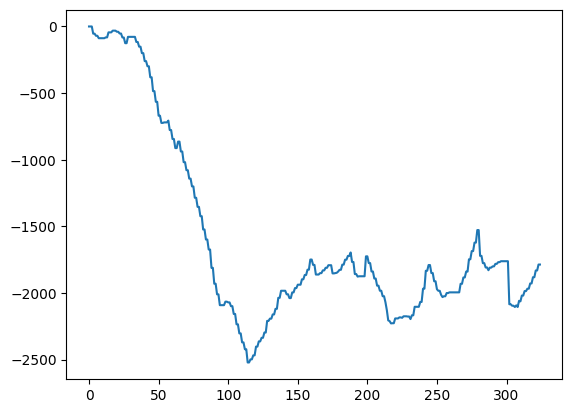

In [246]:
'''
Function: computes the return on a $100 bet based on the row's EV and actual outcome.
For non-negative EVs, it calculates the potential bet size and adjusts it based on whether the prediction was correct.
'''
def returns(x):
    # x['EV'] = -x['EV']
    if x['EV'] < 0:
        return 0
    size = 100 * x['EV']
    if x['over_under']:
        if x['pts'] < x['value']:
            return -size
    else:
        if x['pts'] > x['value']:
            return -size
    if x['odds'] > 0:
        return size * (x['odds'] / 100)
    else:
        return size * (100 / abs(x['odds']))

# Plotting the cumulative returns over time
returns_df['returns'] = returns_df.apply(returns, axis=1)
returns_df['cum_returns'] = returns_df['returns'].cumsum()
returns_df['cum_returns'].plot()

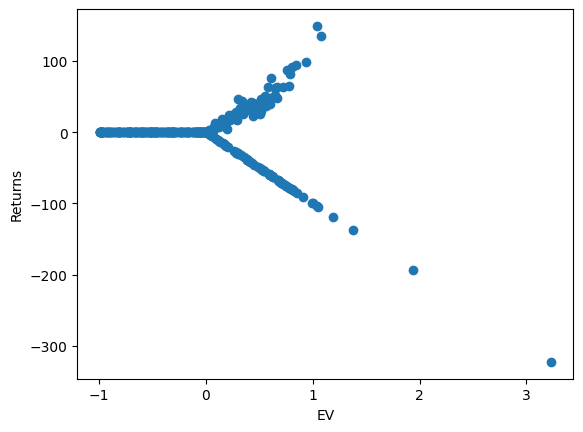

In [247]:
# plot EV vs returns for each day
plt.plot(returns_df['EV'], returns_df['returns'], 'o')
plt.xlabel('EV')
plt.ylabel('Returns')
plt.show()